### Цель работы

Цель исследования — **построить модель, которая предсказывает вероятность снижения покупательской активности клиента в следующие три месяца**
 
В компании выделяют два уровня активности:  
- **«Снизилась»** — если клиент стал покупать меньше товаров;  
- **«Прежний уровень»** — если объём покупок не изменился.

В распоряжении имеются данные о клиентах, включающие следующие группы признаков:
- признаки, описывающие **коммуникацию сотрудников компании с клиентом**;
- признаки, отражающие **продуктовое поведение покупателя** — какие товары покупает и как часто;
- признаки, характеризующие **покупательское поведение** — сколько клиент тратит в магазине;
- признаки, описывающие **поведение клиента на сайте** — сколько страниц просматривает и сколько времени проводит на сайте.

Дополнительно в анализ включаются **данные финансового департамента о прибыльности клиента**, отражающие прибыль, который каждый покупатель принёс компании за последние три месяца.

На основе предсказаний модели и показателей прибыльности необходимо:
- провести **сегментацию клиентов**;
- выделить группу покупателей (сегмент) с различным уровнем риска и ценностью для компании;
- **разработать персонализированные предложения** для удержания выбранного сегмента.


#### Шаг 1 Импорт бибилиотек и загрузка данных 

In [3]:
!pip install shap
!pip install phik

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import shap
import warnings
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyClassifier

In [6]:
# загружаем данные
market_file = pd.read_csv('./market_file.csv')
market_money = pd.read_csv('./market_money.csv')
market_time = pd.read_csv('./market_time.csv')
money = pd.read_csv('./money.csv', sep=';')

# выводим загруженные датафреймы
display(market_file.sample(5))
display(market_money.sample(5))
display(market_time.sample(5))
display(money.sample(5))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
233,215581,Снизилась,стандарт,да,4.0,3,171,0.25,Товары для детей,3,4,3,5
1140,216488,Прежний уровень,стандарт,да,4.1,4,619,0.23,Товары для детей,6,1,1,13
920,216268,Прежний уровень,стандарт,да,4.1,4,327,0.19,Товары для детей,3,1,0,12
168,215516,Снизилась,стандарт,нет,4.4,4,252,0.98,Косметика и аксесуары,3,4,2,1
361,215709,Снизилась,стандарт,нет,4.6,5,352,0.89,Домашний текстиль,1,3,2,6


,id,Период,Выручка
1288,215777,предыдущий_месяц,4670.0
42,215362,предыдущий_месяц,4314.0
2,215348,предыдущий_месяц,0.0
3171,216405,предыдущий_месяц,4637.0
2474,216172,препредыдущий_месяц,4981.0


,id,Период,минут
1993,216344,предыдцщий_месяц,17
2097,216396,предыдцщий_месяц,14
1004,215850,текущий_месяц,16
617,215656,текущий_месяц,10
979,215837,текущий_месяц,18


,id,Прибыль
709,216057,"4,61"
301,215649,"5,71"
566,215914,"5,3"
347,215695,"4,36"
476,215824,"3,66"


**Выводы по шагу**: 
- установили и импортировали необходимые для работы библиотеки
- загрузили датасеты для их дальнейшего изучения и обработки
- вывели каждый датасет, чтобы посмотреть что в нем

#### Шаг 2 Предообработка данных

In [7]:
# функция для предобработки датафреймов, вывода информации о пропусках, явных дубликатах, 
# удаление явных дубликатов, вывод неявных дубликатов для строковых столбцов

def prepare_df(df):
    # приведение наименований столбцов к единому формату
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    print(f'\033[1mИсследование пропусков в датафрейме:\033[0m\n {df.isna().sum()}')
    print('\n')
    print(f'\033[1mКоличество явных дубликатов в датафрейме:\033[0m\n {df.duplicated().sum()}')
    
    if df.duplicated().sum() > 0:
        df = df.drop_duplicates()
        print('Явные дубликаты удалены')
        
    # приводим все значения в строковых столбцах к нижнему регистру, пробелы заменяем на _
    df = df.apply(lambda col: col.str.lower().str.replace(' ', '_') if col.dtype == 'object' else col)

    print('\n\033[1mУникальные значения в строковых столбцах:\033[0m')

    col_str = df.select_dtypes(include='object').columns
    print(f'\033[1mКоличество строковых столбцов: {len(col_str)}\033[0m')
    
    if len(col_str) != 0:
        for col in col_str:
            uniques = df[col].unique()
            print(f'{col}: {uniques}')
    
    return df

In [8]:
# выводим общую информацию о датасете market_file
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
# запускаем функцию для предобработки
market_file = prepare_df(market_file)

Исследование пропусков в датафрейме:
 id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


Количество явных дубликатов в датафрейме:
 0

Уникальные значения в строковых столбцах:
Количество строковых столбцов: 4
покупательская_активность: ['снизилась' 'прежний_уровень']
тип_сервиса: ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать: ['да' 'нет']
популярная_категория: ['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытова

In [11]:
# удаляем неявные дубликаты
market_file['тип_сервиса'] = market_file['тип_сервиса'].apply(lambda x: 'стандарт' if x == 'стандартт' else x)

In [12]:
# изучаем второй датасет market_money и запускаем функцию для его предобработки
market_money.info()
market_money = prepare_df(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
Исследование пропусков в датафрейме:
 id         0
период     0
выручка    0
dtype: int64


Количество явных дубликатов в датафрейме:
 0

Уникальные значения в строковых столбцах:
Количество строковых столбцов: 1
период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [13]:
# изучаем третий датасет market_time и запускаем функцию для его предобработки
market_time.info()
market_time = prepare_df(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
Исследование пропусков в датафрейме:
 id        0
период    0
минут     0
dtype: int64


Количество явных дубликатов в датафрейме:
 0

Уникальные значения в строковых столбцах:
Количество строковых столбцов: 1
период: ['текущий_месяц' 'предыдцщий_месяц']


In [14]:
# исправляем опечатку в периоде
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [15]:
# предобработка последнего датасета money

money.info()
# меняем запятую на точку в колонке прибыль
money['Прибыль'] = money['Прибыль'].str.strip().str.replace(',', '.').astype(float)

money = prepare_df(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
Исследование пропусков в датафрейме:
 id         0
прибыль    0
dtype: int64


Количество явных дубликатов в датафрейме:
 0

Уникальные значения в строковых столбцах:
Количество строковых столбцов: 0


**Вывод по шагу**: 
- предобработали все датасеты: явных дубликатов не было, наименования столбцов сделали в нижнем регистре, значения в строковых столбцах также привели к нижнему регистру, исправили опечатки в строковых столбцах, привели данные к верным типам

### Шаг 3 Исследовательский анализ данных

In [16]:
# функция для исследовательского анализа данных
def data_analysis(df):
    display(df.drop(columns='id').describe())
    # делим колонки на категориальные и количественные
    # маркет_актив_тек_мес, средний_просмотр_категорий_за_визит включаем в категориальную, так как значения дискретные
    exclude_cols = ['id', 'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']
    discrete_cat = [col for col in exclude_cols if col != 'id']
    
    num_cols = [col for col in df.select_dtypes(exclude='object').columns if col not in exclude_cols]
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    
    for col in discrete_cat:
        if col in df.columns:
            cat_cols.append(col)
    
    # строим гистограмму для количественных признаков
    n_cols = 3
    n_rows_num = (len(num_cols) + n_cols - 1) // n_cols
    n_rows_cat = (len(cat_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(3 * n_cols, 3 * n_rows_num))
    
    for i, col in enumerate(num_cols):
        plt.subplot(n_rows_num, n_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=20)
        mean_val = df[col].mean()
        plt.axvline(mean_val, color="red", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.2f}")
        median_val = df[col].median()
        plt.axvline(median_val, color="blue", linestyle=":", linewidth=2, label=f"Median = {median_val:.2f}")
        plt.title(f'{col}', fontsize=10)
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.legend()
    
    plt.tight_layout(pad=2)
    plt.show()
    
    # строим ящик с усами для количественных признаков
    plt.figure(figsize=(3 * n_cols, 3 * n_rows_num))
    
    for i, col in enumerate(num_cols):
        plt.subplot(n_rows_num, n_cols, i + 1)
        sns.boxplot(y=df[col])
        mean_val = df[col].mean()
        plt.axhline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.2f}')
        median_val = df[col].median()
        plt.axhline(median_val, color="blue", linestyle=":", linewidth=2, label=f"Median = {median_val:.2f}")
        plt.title(f'{col}')
        plt.legend(loc='upper center', bbox_to_anchor=(0, -0.05))
    
    plt.tight_layout(pad=2)
    plt.show()
    
    # строим столбчатые диаграммы для категориальных признаков
    plt.figure(figsize=(16, 4 * n_rows_cat))
    
    for i, col in enumerate(cat_cols):
        ax = plt.subplot(n_rows_cat, n_cols, i + 1)
        counts = df[col].value_counts()
        if col == 'популярная_категория':
            sns.barplot(y=counts.index, x=counts.values, ax=ax)
            ax.set_xlabel('Количество', fontsize=8)
            ax.set_ylabel(col, fontsize=8)
            ax.tick_params(axis='y', labelsize=7)
        else:
            sns.barplot(x=counts.index, y=counts.values, ax=ax)
            ax.set_title(f'{col}', fontsize=10)
            ax.set_ylabel('Количество', fontsize=8)
            ax.set_xlabel(col, fontsize=8, )
            ax.tick_params(axis='x', labelsize=7)
        
    plt.tight_layout()
    plt.show()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


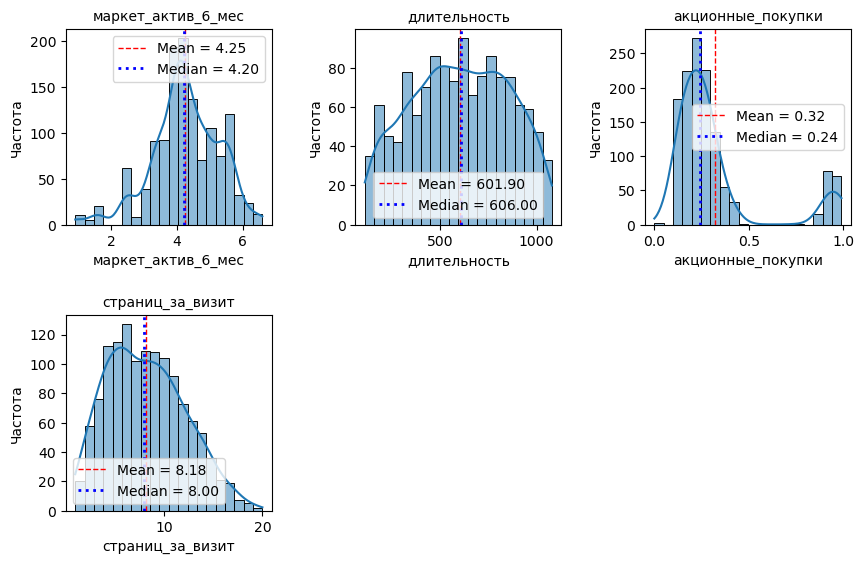

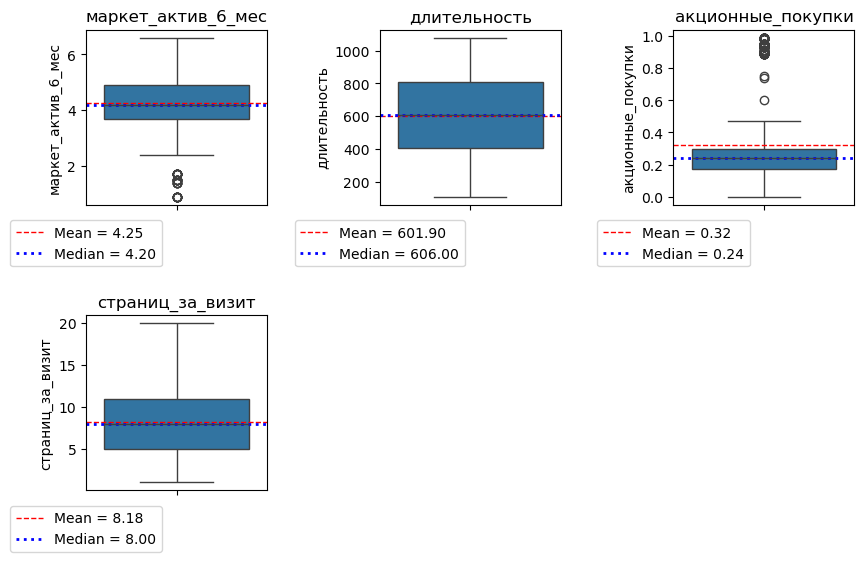

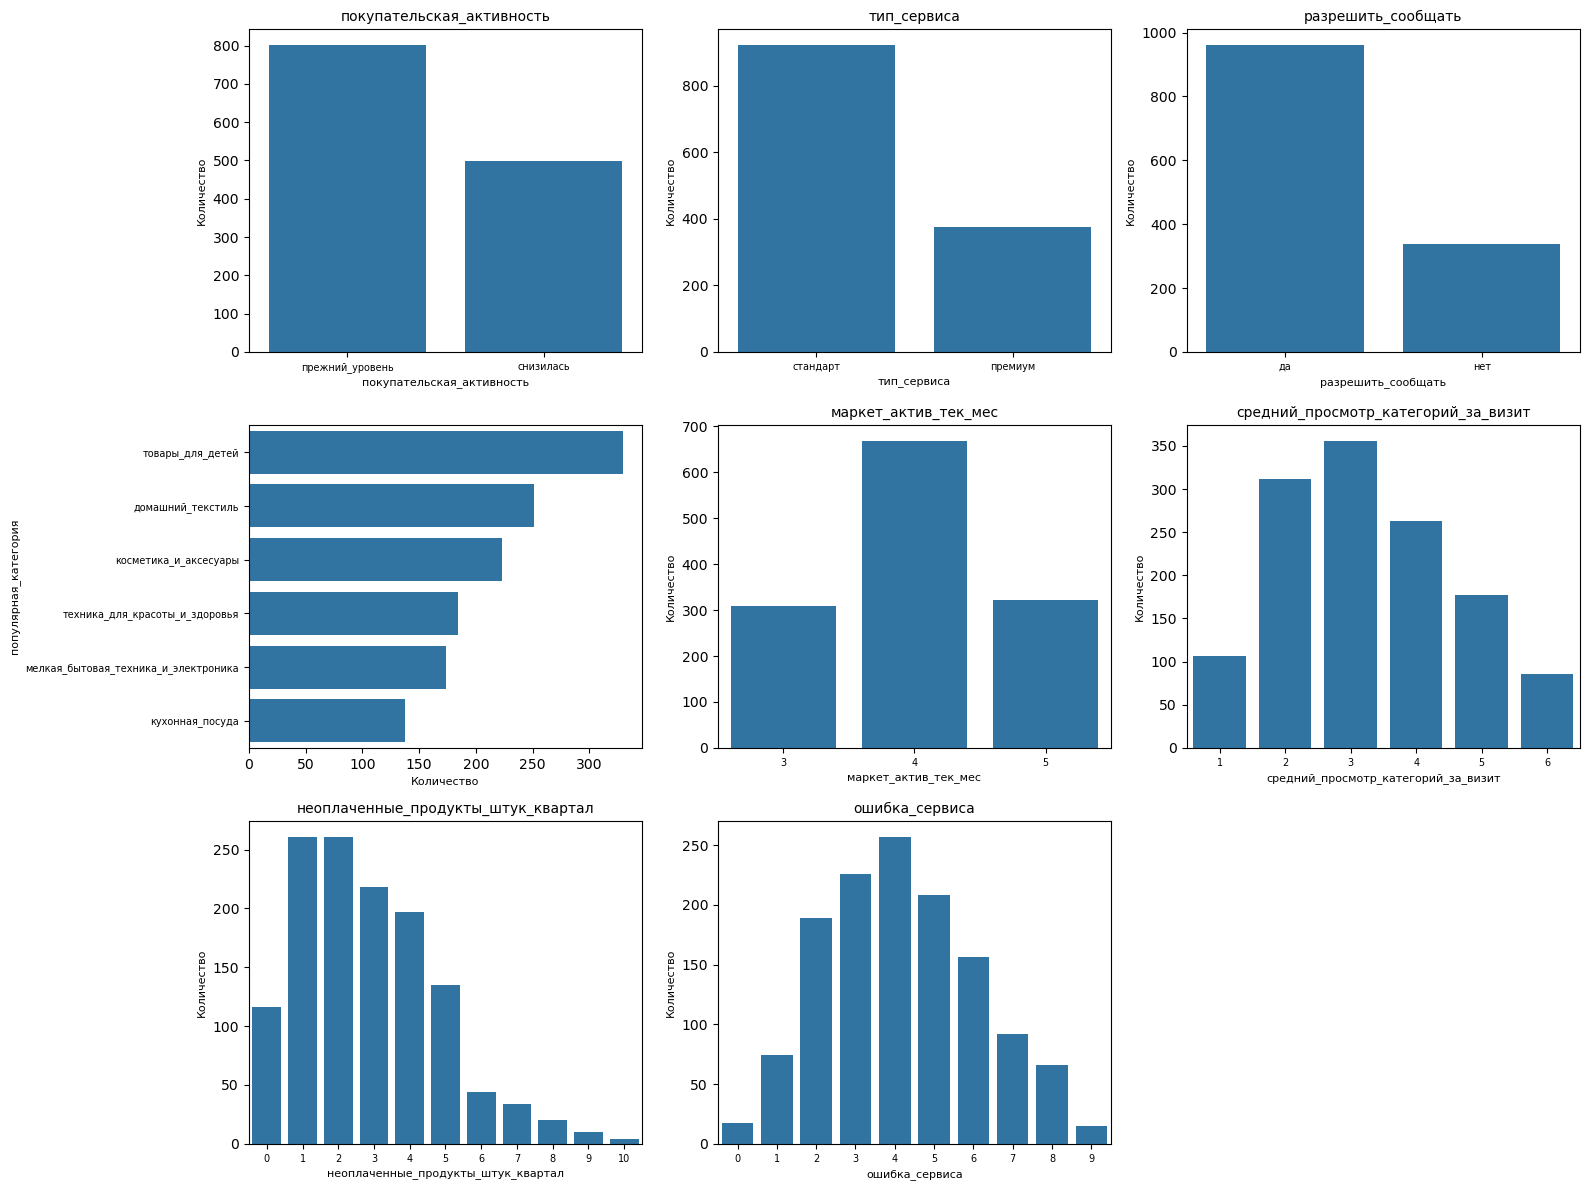

In [17]:
# исследуем датасет market_file
data_analysis(market_file)

1. маркетинговая активность за последние 6 мес
- Распределение близко к нормальному, но чуть скошено вправо
- Большинство значений — около 4–5
- Вывод: стабильная маркетинговая активность, но есть пользователи с которыми взаимодействовали менее 2х раз за полгода

2. длительность
- Почти равномерное распределение с лёгким спадом справа. Минимальное значение 110, значит новых клиентов не было за почти 4 месяца
- Средняя и медиана практически совпадают

3. доля акционных покупок
- Очень сильно скошено вправо: большинство близко к нулю, небольшое количество пользователей покупают только акциям
- Большинство клиентов почти не совершают акционные покупки (медиана = 0.24, 24%), но некоторые покупают только акциям (значения у 1)

4. страниц за визит
- среднее и медиана почти равны
- выбросов нет
- распределение близко к нормальному

5. покупательская активность
- Большинство клиентов сохраняют прежний уровень активности

6. тип сервиса:
- стандарт превышает премиум в два раза

7. разрешение на расслыки:
- почти все согласны на рассылки

8. популярная категория:
- лидеры: товары для детей, домашний текстиль, косметика и аксессуары
- портрет аудитории уже видно: семья + комфорт + уход. Возможно, это пригодится для персонализации рекомендаций

9. маркетинговая активность в тек мес:
- взаимодействий от 3 до 5

10. средний просмотр категорий за визит:
- чаще всего люди смотрят 2-3 категории

11. неоплаченные продукты за квартал:
- чаще не превышает 5
- есть пользователи с 10 неоплаченными товарами

12. ошибка сервиса:
- большинство ошибок в диапазоне 2-5


,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


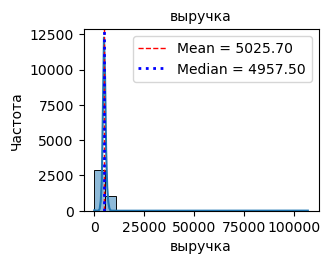

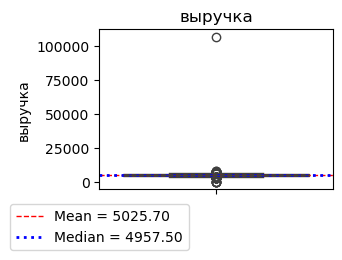

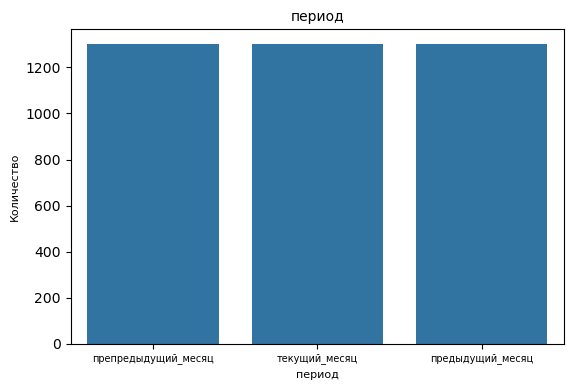

In [18]:
# исследуем датасет market_money
data_analysis(market_money)

,выручка
count,3899.00000
mean,4999.57743
std,706.99988
min,0.00000
25%,4590.10000
50%,4957.00000
75%,5363.00000
max,7799.40000


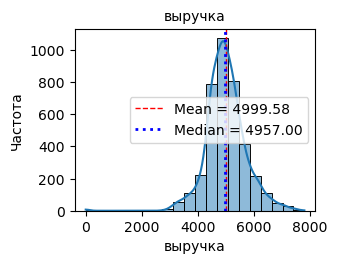

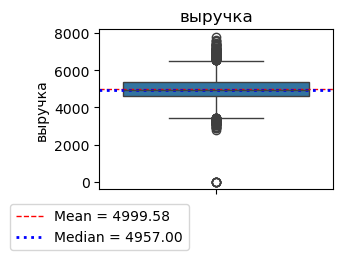

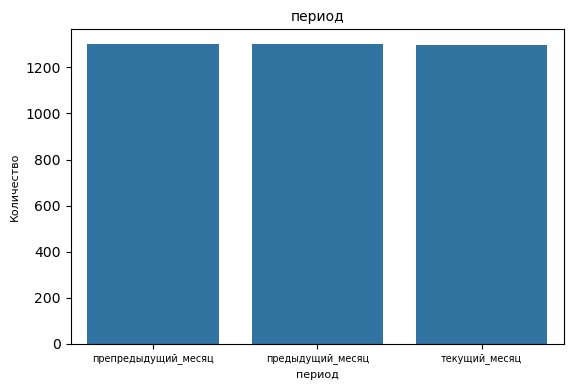

In [19]:
# удаляем строчку, которая явно похожа на выброс и проводим анализ снова
market_money = market_money.query('выручка <= 100000')
data_analysis(market_money)

Теперь распределение похоже на нормальное, данные сбалансированы во всех трех периодах

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


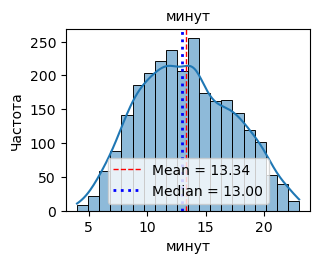

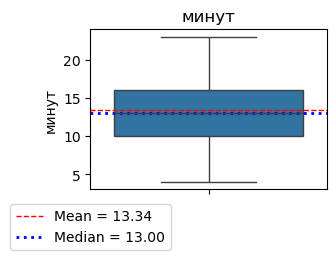

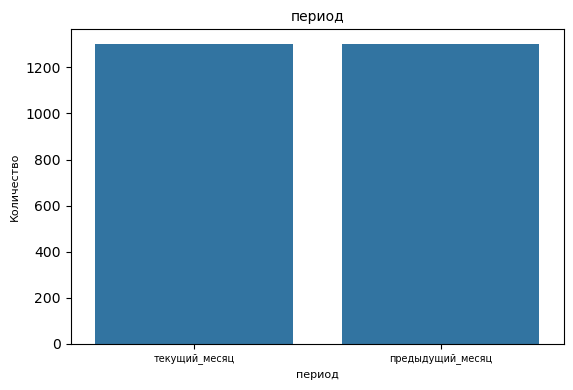

In [20]:
# исследуем датасет market_time
data_analysis(market_time)

- Распредение нормальное
- В среднем люди проводят 13 минут на сайте
- В текущем и предыдущем месяце ничего не менялось

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


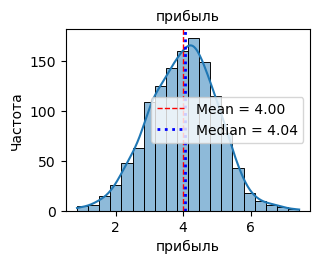

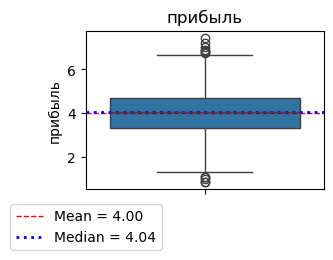

<Figure size 1600x0 with 0 Axes>

In [21]:
# исследуем датасет money
data_analysis(money)

- распределение похоже на нормальное
- среднее и медиана почти равны
- явных выбросов нет

In [22]:
# отбираем клиентов с выручкой > 0 в каждом периоде
mask_id = (
    market_money
    .groupby('id')['выручка']
    .apply(lambda x: (x > 0).all())
)

mask_id = mask_id[mask_id].index

market_file = market_file[market_file['id'].isin(mask_id)]
market_money = market_money[market_money['id'].isin(mask_id)]
market_time = market_time[market_time['id'].isin(mask_id)]

#проверяем размерность отфильтрованных датасетов
print(market_file.shape, market_money.shape, market_time.shape)

(1297, 13) (3890, 3) (2594, 3)


**Выводы по шагу:**
- провели исследовательский анализ всех датасетов
- удалили в датасетах выбросы, если они были
- построили гистограммы распредения для количественных признаков, а также столбцатые диаграммы для категориальных или дискретных. Аномальных распределений не было, можем работать дальше
- изучили статистические характеристики для каждого датасета

#### Шаг 4 Объединение таблиц

In [23]:
# объединяем таблицы по id пользователя

market_full = market_file.merge(market_money, on='id').merge(market_time, on='id')

# делаем сводные таблицы, чтобы не дублировать id строках
market_full_final = (
    market_full.drop(columns=['период_x', 'период_y', 'выручка', 'минут'])
    .drop_duplicates(subset='id')
    .merge(
        market_full.pivot_table(index='id', columns='период_x', values='выручка', aggfunc='first')
        .rename(columns=lambda x: f'выручка_{x}'),
        on='id', how='left'
    )
    .merge(
        market_full.pivot_table(index='id', columns='период_y', values='минут', aggfunc='first')
        .rename(columns=lambda x: f'минут_{x}'),
        on='id', how='left'
    )
)

# проверяем размерность полученного датасета
market_full_final.shape


(1297, 18)

In [24]:
# изучаем полученный датасет
market_full_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

1 пропуск в столбце выручка_текущий_месяц, оставим пока его. будем его заполнять в будущем пайплайне

In [25]:
# заменяем индекс на id, так как id является уникальным
market_full_final = market_full_final.set_index('id')

# проверяем размерность полученного датасета
market_full_final.shape

(1297, 17)

**Выводы по шагу**:
- объединили датасеты в один для будущего моделирования
- преобразовали датасет так, чтобы в нем вся информация была в строке с id пользователя и id пользователя не дублировались в других строках. Для этого были использованы сводные таблицы
- проверили размерность полученного датасета

#### Шаг 5 Корреляционный анализ

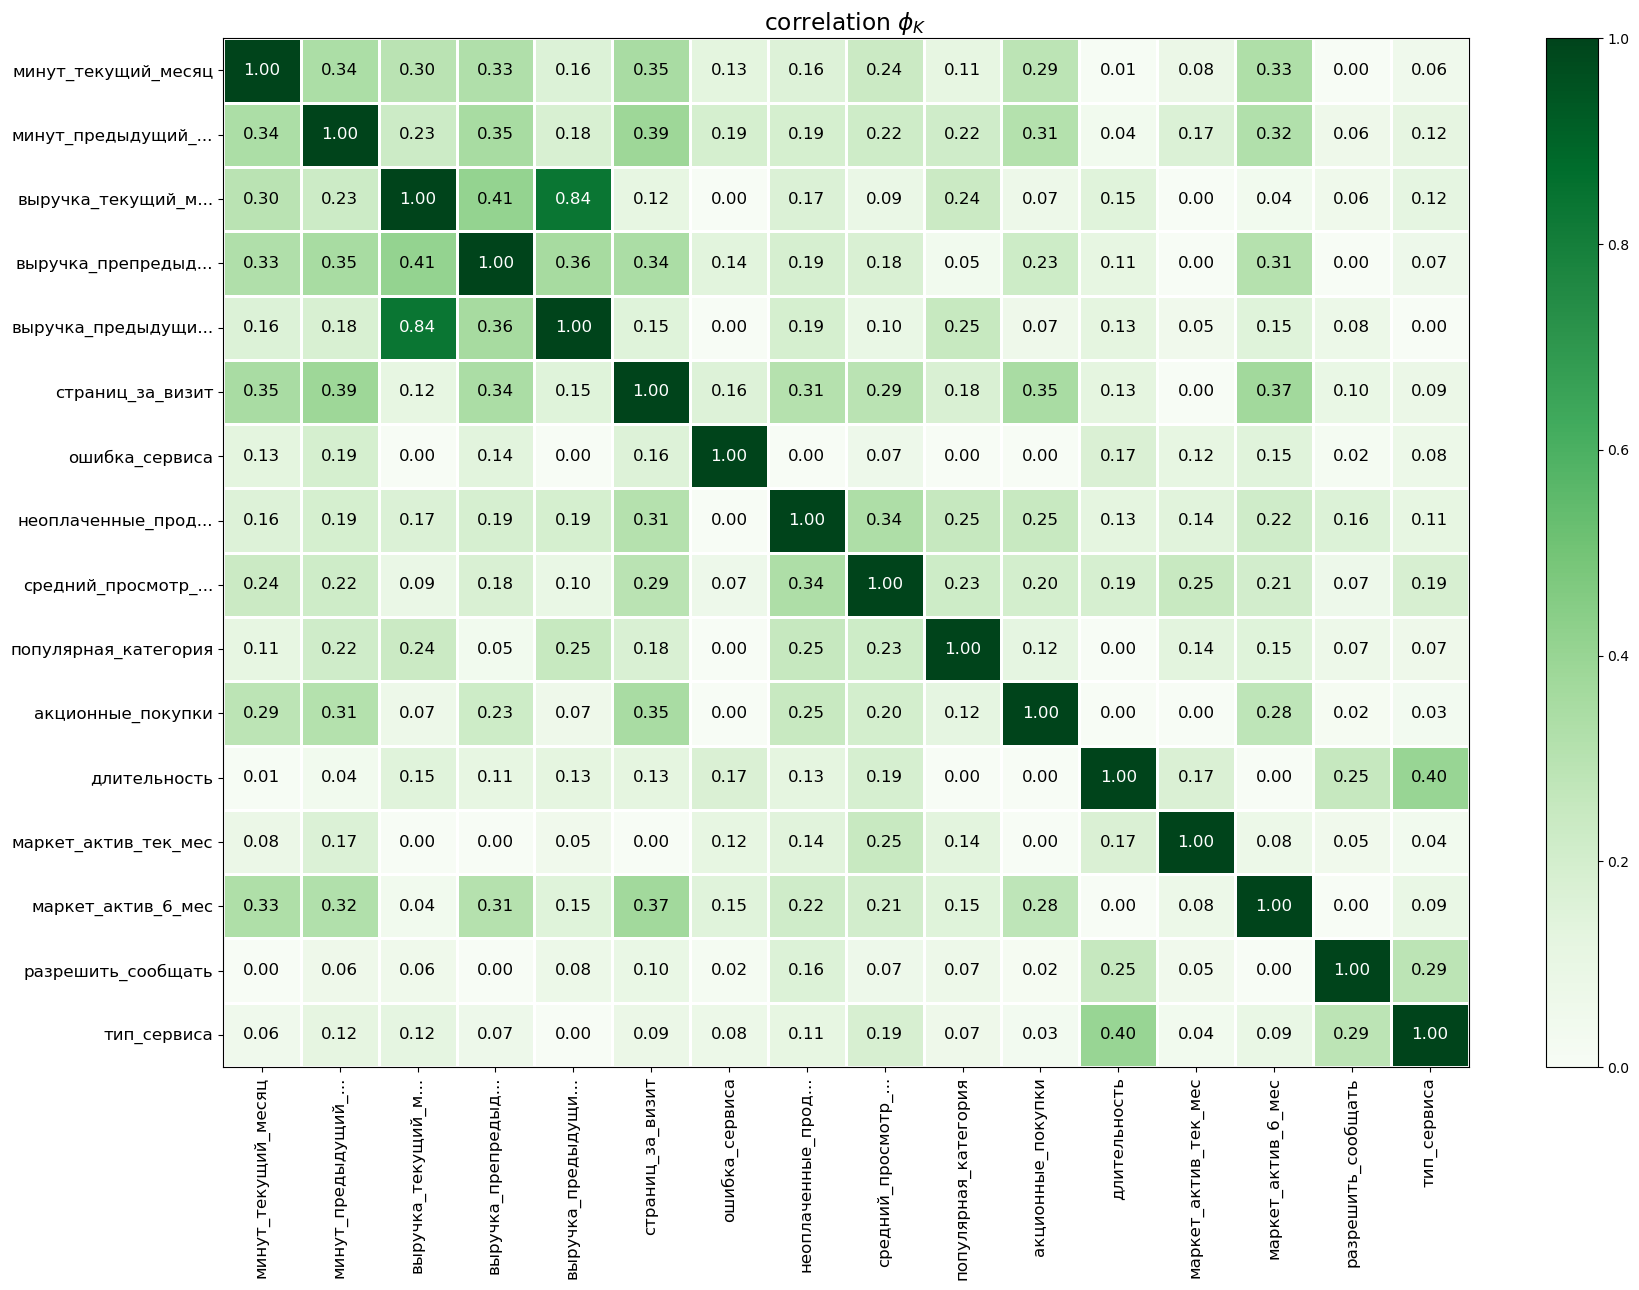

In [26]:
# список непрерывных признаков
interval_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

# целевой признак убираем, т.к. основная идея посмотреть на мультиколлинеарность других признаков
phik_overview = phik_matrix(market_full_final.drop(columns='покупательская_активность'), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(18, 13)
)

**Выводы по шагу:**
***Сильные взаимосвязи***
- выручка_текущий_месяц — выручка_предыдущий_месяц (0.70). Покупательская выручка по месяцам стабильно связана — клиенты с высокой выручкой в прошлом месяце, как правило, приносят аналогичную выручку и сейчас
- выручка_текущий_месяц — акционные_покупки (0.75). Очень высокая зависимость: клиенты, активно участвующие в акциях, приносят часть выручки => Акции стимулируют продажи
- выручка_предыдущий_месяц - акционные_покупки (0.64) => можно предположить, что акции формируют долгосрочную привычку покупать

***Средние взаимосвязи***
- страницы_за_визит — минут_предыдущий_месяц (0.39) => чем больше страниц просматривает клиент, тем больше времени проводит на сайте
- тип_сервиса — длительность (0.41) => разные паттерны поведения у пользователей с разным типом подписки
- минут_текущий_месяц - минут_предыдущий_месяц (0.34) => поведение клиента относительно стабильное по времени активности
- маркет_актив_6_мес - минут_текущий_месяц (0.33) => те, кто активен в маркетинговых каналах, чаще взаимодействуют с платформой

Мультиколинеарности (связь больше > 0.80 - 0.85) не наблюдается.

#### Шаг 6 Использование пайплайнов

In [27]:
# проверяем баланс целевого признака для выбора метрики оценки моделей
market_full_final['покупательская_активность'].value_counts(normalize=True)

покупательская_активность
прежний_уровень    0.61835
снизилась          0.38165
Name: proportion, dtype: float64

Выберем основную метрику roc_auc, т.к. перед нами стоит задача бинарной классификации и важно измерить способность модели различать классы.
Метрика ROC-AUC устойчива к выбору порога классификации и подходит для сравнительного анализа моделей

In [28]:
# создание пайплайнов для масшатабирования и кодирования данных
RANDOM_STATE = 66

# столбцы для масштабирования
num_cols = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]

# столбцы для кодирования
ohe_cols = ['популярная_категория']
ord_cols = ['тип_сервиса', 'разрешить_сообщать']

In [29]:
# выделяем целевую метрику
target = 'покупательская_активность'
X = market_full_final.drop(columns=target)
y = market_full_final[target]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,          
    random_state=RANDOM_STATE,
    stratify=y
)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [31]:
# пайплайн для кодирования категориальных переменных
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])
# пайплайн для кодирования тип_сервиса с учетом порядка (премиум лучше стандарта), а также разрешить_сообщать
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['стандарт', 'премиум'], ['нет', 'да']],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan
    ))
])

# пайплайн для масштабирования количественных столбцов
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# словарь гиперпараметров и моделей
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
        # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
         'models__C': loguniform(1e-3, 1e2),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# используем рандомизированный поиск гиперпараметров и моделей, чтобы сократить время
search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=25,
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# обучаем модель
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImput...
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(random_state=66)],
                                         'models__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31551dee0>,
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=66, scoring='roc_auc')

In [32]:
# выводим лучшую модель и гиперпараметры для нее, метрика для оценки roc_auc
print(f"Лучшая модель: {type(search.best_estimator_.named_steps['models']).__name__}")
print(f"Параметры модели:")
for param, val in search.best_params_.items():
    print(f"   {param}: {val}")
print(f"\nСредний ROC-AUC (кросс-валидация): {search.best_score_:.3f}")

Лучшая модель: SVC
Параметры модели:
   models: SVC(probability=True, random_state=66)
   models__kernel: rbf
   preprocessor__num__scaler: StandardScaler()

Средний ROC-AUC (кросс-валидация): 0.916


In [33]:
# проверяем модель на тестовой выборке
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC на тестовой выборке: {roc_auc:.4f}\n")

ROC-AUC на тестовой выборке: 0.9065



In [34]:
# проверка модели на адекватность с помощью DummyClassifier

dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

y_pred_proba = dummy_model.predict_proba(X_test)[:, 1]

dummy_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC на тестовой выборке DummyClassifier:', round(dummy_roc_auc, 4)) 

ROC-AUC на тестовой выборке DummyClassifier: 0.5


**Вывод**: наша модель вполне адекватна, у baseline метрика намного хуже.

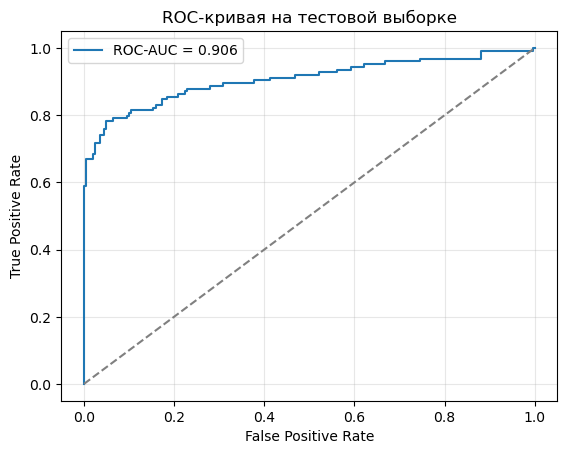

In [36]:
# строим график roc-кривой
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC-кривая на тестовой выборке")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Выводы по шагу:**
- написали пайпланы для масштабирования и кодирования данных
- для выбора и сравнения моделей была выбрана метрика roc_auc, она устойчива к выбору порога классификации и подходит для сравнительного анализа моделей
- в кросс-валидации были проверены и сравнены 4 модели: KNeighborsClassifier, DecisionTreeClassifier, SVC, LogisticRegression, два скалера: StandardScaler, MinMaxScaler, для категориальных данных использовали кодировщики OneHotEncoder и OrdinalEncoder, для заполнения пропусков использовали SimpleImputer
- результатом стала лучшая модель метода опорных векторов SVC с ядром rbf и скалером StandardScaler
- метрика roc_auc у лучшей подели = 0,916, это высокий показатель
- при проверке на тестовой выборке метрика roc_auc у выбранной модели = 0,9016, также это высокий показатель, т.е. модель показала себя хорошо и на тестовой выборке
- roc-кривая близка к идеальной
- проверили адекватность нашей модели по сравнению с dummy-моделью, выбранная модель SVC модель оказалась лучше.

#### Шаг 7 Анализ важности признаков

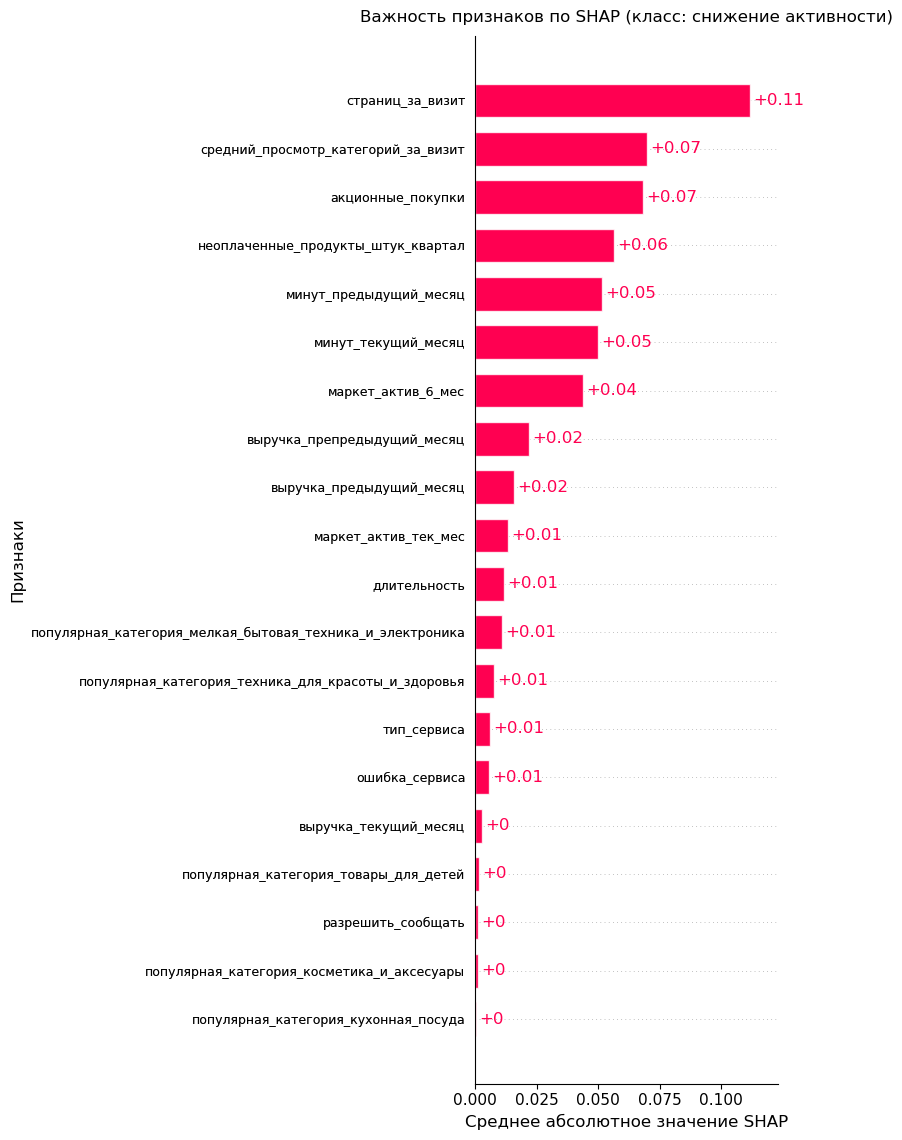

In [37]:
warnings.filterwarnings("ignore", message="X has feature names, but")

ohe_feature_names = best_model.named_steps['preprocessor'] \
    .named_transformers_['ohe'] \
    .named_steps['ohe'] \
    .get_feature_names_out(ohe_cols)

feature_names = np.concatenate([ohe_feature_names, ord_cols, num_cols])

X_sample = X_train.sample(30, random_state=RANDOM_STATE)

X_prepared = best_model.named_steps['preprocessor'].transform(X_sample)
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)

explainer = shap.Explainer(best_model.named_steps['models'].predict_proba, X_prepared_df)
shap_values = explainer(X_prepared_df)

# влияние на снижение активности
shap_fig = shap.plots.bar(shap_values[:, :, 1], max_display=20, show=False)

plt.title('Важность признаков по SHAP (класс: снижение активности)', fontsize=12, pad=10)
plt.xlabel('Среднее абсолютное значение SHAP', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


**Малозначимые признаки**
- длительность, ошибка_сервиса, тип_сервиса почти не влияют на предсказание, вероятно, не несут информации об активности
- популярная_категория, разрешить_сообщать имеют близкий к нулю вклад, пользователи покупающие разные категории ведут себя схоже

**Наиболее важные признаки**
- страниц_за_визит: больше страниц за визит означает более вовлечённого покупателя
- минут_текущий_месяц, минут_предыдущий_месяц: чем больше времени пользователь проводит на площадке, тем выше вероятность активности
- акционные_покупки: участие в акциях повышает шансы быть активным покупателем
- средний_просмотр_категорий_за_визит: чем разнообразнее интересы пользователя, тем выше вовлечённость и вероятность активности
- неоплаченные_продукты_штук_квартал: отражает потенциальный интерес — пользователи, часто добавляющие товары без оплаты, остаются активными и вовлечёнными

**Для принятия бизнес-решений**
- ранняя диагностика оттока: падение показателей по страницам или минутам — сигнал о снижении активности
- маркетинговый таргетинг: пользователи, активно участвующие в акциях, — ключевая аудитория для персональных предложений
- ремаркетинг: пользователи с неоплаченными товарами — кандидаты для напоминаний и допродаж
- финансовая сегментация: анализ выручки помогает различать постоянных и сезонных клиентов.

#### Шаг 8 Сегментация покупателей

Будем рассматривать сегмент пользователей: группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

In [38]:
# объединяем итоговую таблицу с данными о прибыльности пользователей
segment = market_full_final.merge(money, on='id')
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

In [39]:
# создаем столбец с вероятностью отнесения к классу 1 (класс 1 - снижение активности)
segment['prob_down'] = best_model.predict_proba(segment.drop(columns=target))[:, 1]
segment.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль,prob_down
673,216024,прежний_уровень,стандарт,да,2.6,4,389,0.17,домашний_текстиль,2,2,6,7,4847.0,5615.0,4311.4,20,14,4.60,0.099002
462,215813,снизилась,стандарт,да,3.6,5,446,0.17,домашний_текстиль,6,2,4,12,5034.5,5051.0,5150.2,15,20,4.54,0.123953
618,215969,прежний_уровень,стандарт,да,4.1,5,132,0.28,техника_для_красоты_и_здоровья,5,2,3,8,3803.0,4506.0,4542.7,12,10,2.45,0.116302
1047,216398,прежний_уровень,стандарт,нет,5.7,3,1010,0.15,товары_для_детей,3,0,6,3,4439.0,4935.0,4999.3,15,19,3.87,0.041031
1027,216378,прежний_уровень,премиум,да,5.7,3,636,0.14,товары_для_детей,3,2,7,11,4263.0,4857.0,4907.8,14,16,2.95,0.038261


In [40]:
# высокой прибылью будем считать то, что выше медианного значения
# высокой вероятностью снижения активности - там, где вероятность > 0.7 по прогнозам лучшей модели
profit_threshold = segment['прибыль'].median()

segment_target = segment[
    (segment['prob_down'] > 0.7) &
    (segment['прибыль'] > profit_threshold)
]

segment_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 1285
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   198 non-null    int64  
 1   покупательская_активность            198 non-null    object 
 2   тип_сервиса                          198 non-null    object 
 3   разрешить_сообщать                   198 non-null    object 
 4   маркет_актив_6_мес                   198 non-null    float64
 5   маркет_актив_тек_мес                 198 non-null    int64  
 6   длительность                         198 non-null    int64  
 7   акционные_покупки                    198 non-null    float64
 8   популярная_категория                 198 non-null    object 
 9   средний_просмотр_категорий_за_визит  198 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   198 non-null    int64  
 11  ошибка_сервиса                      

Получили сегмент, состоящий из 200 пользователей

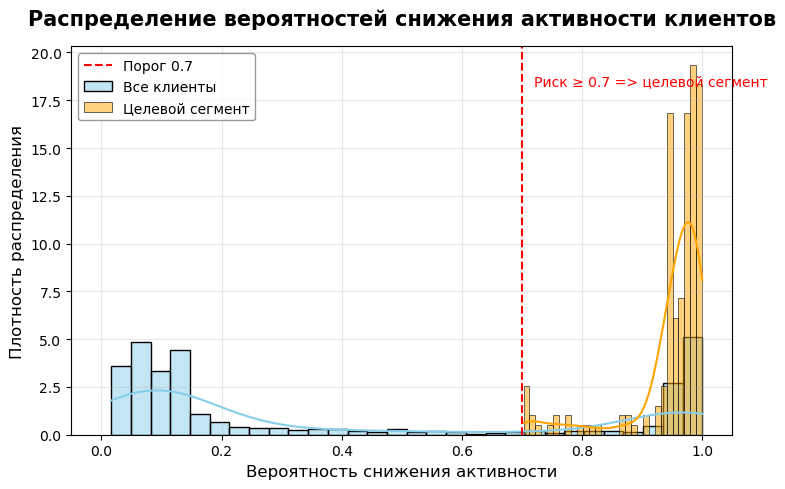

In [41]:
# визуально отобразим отобранный сегмент покупателей
plt.figure(figsize=(8, 5))

sns.histplot(segment['prob_down'], bins=30, alpha=0.5, label='Все клиенты',
             stat='density', common_norm=False, color='skyblue', kde=True)
sns.histplot(segment_target['prob_down'], bins=30, alpha=0.5, label='Целевой сегмент',
             stat='density', common_norm=False, color='orange', kde=True)

plt.xlim(-0.05, 1.05)
plt.ylim(0, None)

plt.axvline(0.7, color='r', linestyle='--', label='Порог 0.7')
plt.text(0.72, plt.ylim()[1]*0.9, 'Риск ≥ 0.7 => целевой сегмент', color='r', fontsize=10)

plt.title('Распределение вероятностей снижения активности клиентов', fontsize=15, weight='bold', pad=15)
plt.xlabel('Вероятность снижения активности', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=10, frameon=True, edgecolor='gray')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


По графику распределения видно, что плотность вероятностей для клиентов с высокой склонностью к снижению активности резко возрастает при значениях выше 0.85.
Это указывает на наличие отдельной группы клиентов с крайне высоким риском оттока.

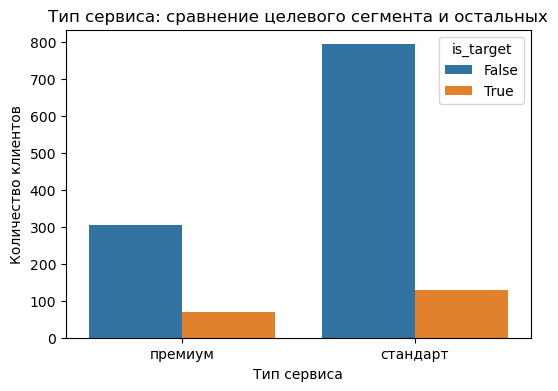

In [42]:
# посмотрим как распреден целевой сегмент по сравнению с другими при выборе типа сервиса

segment['is_target'] = segment.index.isin(segment_target.index)
segment.groupby(['тип_сервиса', 'is_target'])['id'].count().unstack().fillna(0)

plt.figure(figsize=(6,4))
sns.countplot(data=segment, x='тип_сервиса', hue='is_target')
plt.title('Тип сервиса: сравнение целевого сегмента и остальных')
plt.xlabel('Тип сервиса')
plt.ylabel('Количество клиентов')
plt.show()


Основной риск снижения активности сосредоточен в стандартном сервисе.
Это сигнал к тому, что стандартные пользователи приносят значимую прибыль и нуждаются в удерживающих мерах.

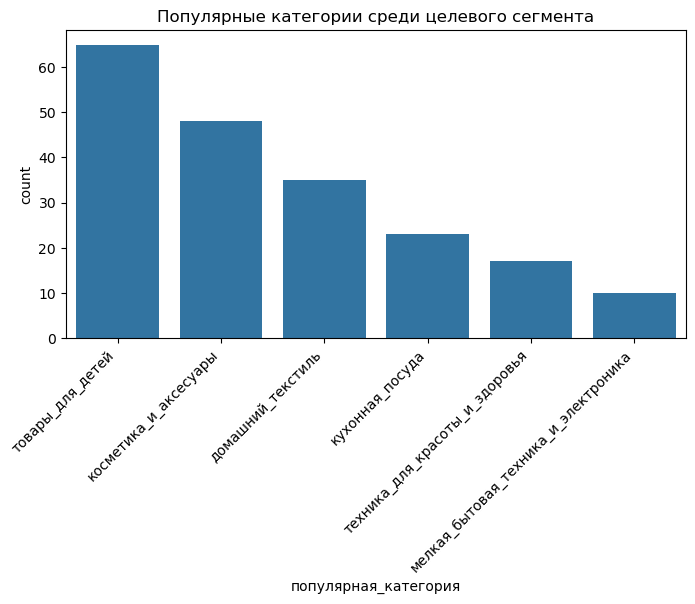

In [43]:
# изучим какие категории товаров покупают пользователи выбранного сегмента

plt.figure(figsize=(8,4))
sns.countplot(data=segment_target, x='популярная_категория',
              order=segment_target['популярная_категория'].value_counts().index)
plt.title('Популярные категории среди целевого сегмента')
plt.xticks(rotation=45, ha='right')
plt.show()


In [44]:
# функция для построения ящика с усами по категориям
def plot_feature_boxplot(df, feature, target_col='is_target', figsize=(7,4)):

    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x=target_col, y=feature)
    
    plt.title(f'{feature}: целевой сегмент vs остальные', fontsize=12, pad=15, wrap=True)
    plt.xlabel('Целевой сегмент', fontsize=10, labelpad=10)
    plt.ylabel(feature, fontsize=10, labelpad=10)
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

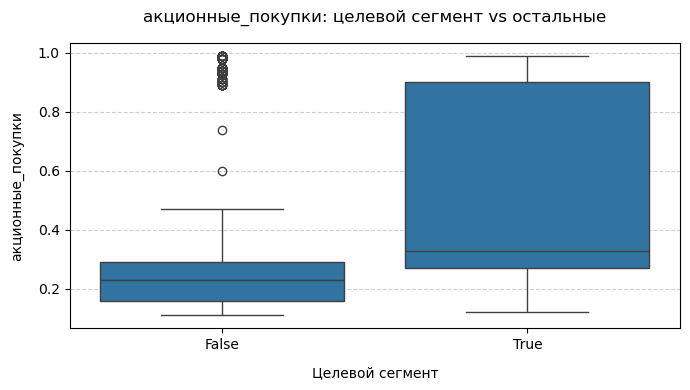

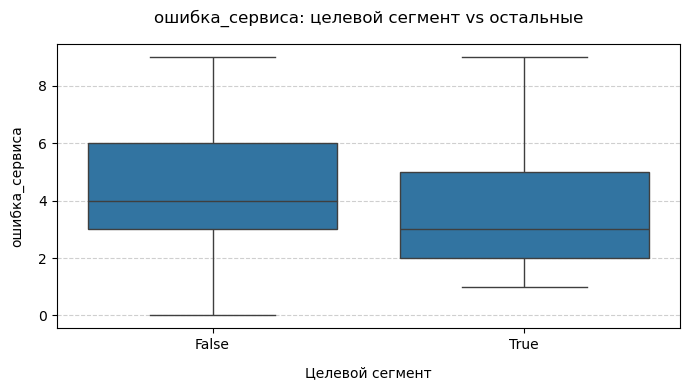

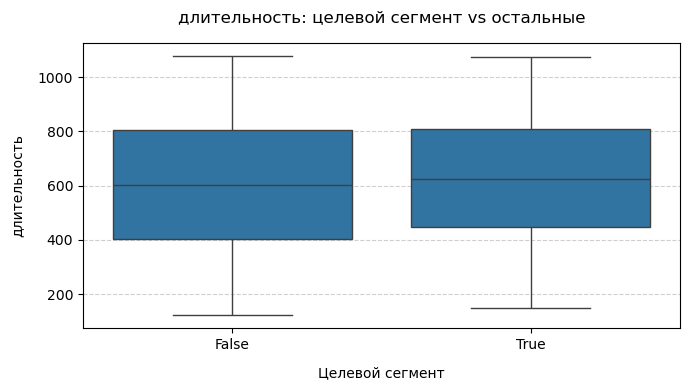

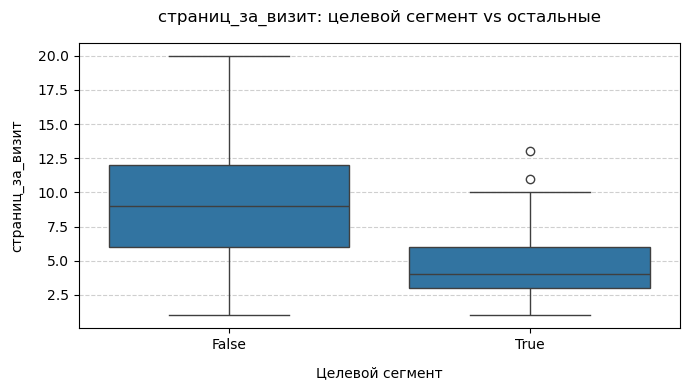

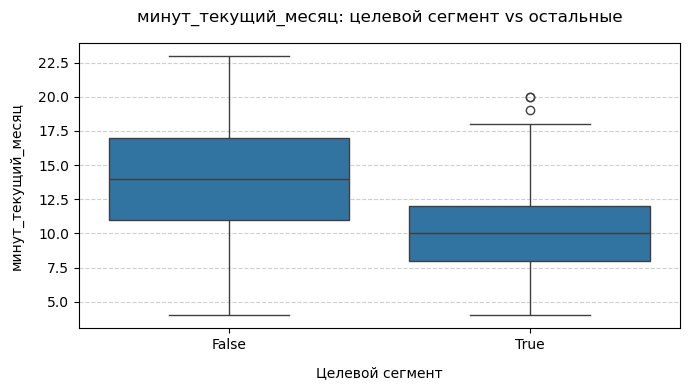

In [45]:
plot_feature_boxplot(segment, 'акционные_покупки')
plot_feature_boxplot(segment, 'ошибка_сервиса')
plot_feature_boxplot(segment, 'длительность')
plot_feature_boxplot(segment, 'страниц_за_визит')
plot_feature_boxplot(segment, 'минут_текущий_месяц')

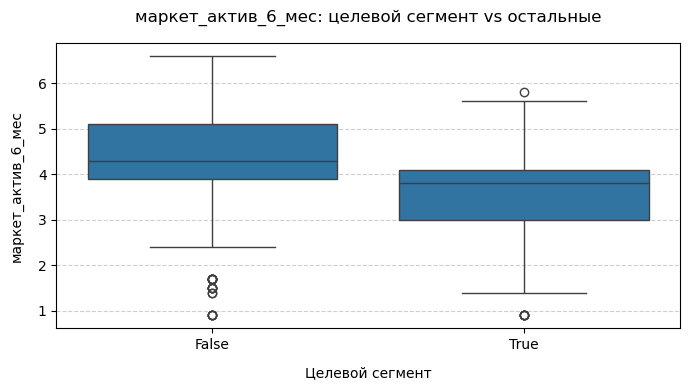

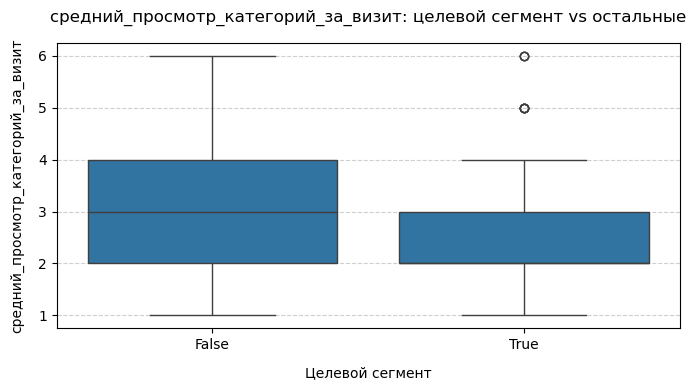

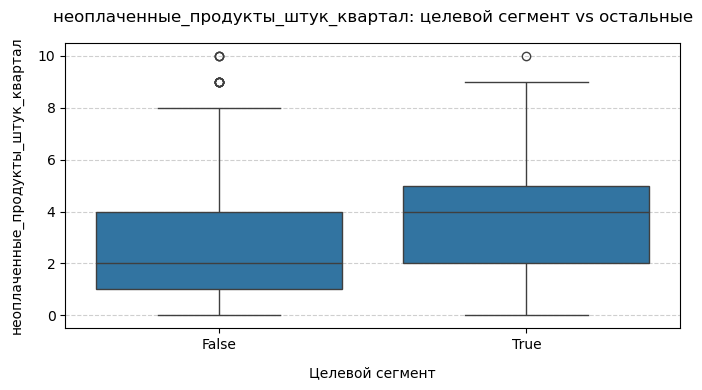

In [46]:
plot_feature_boxplot(segment, 'маркет_актив_6_мес')
plot_feature_boxplot(segment, 'средний_просмотр_категорий_за_визит')
plot_feature_boxplot(segment, 'неоплаченные_продукты_штук_квартал')

**Выводы по шагу**

Был выбран сегмент пользователей с высокой прибыльностью (больше медианного значения) и высоким риском снизить активность (вероятность снижения активности по прогнозу лучшей модели > 0.7)

Построили графики, которые позволили сделать следущие заключения по выбранному сегменту:
- клиенты чаще остальных совершают акционные покупки
- самые популярные категории: товары для детей, косметика и аксессуары и домашний текстиль
- повышенное количество ошибок сервиса не является главным фактором оттока. Диапазон количества ошибок сервиса больше не у категории сегмента
- длительность также не влияет отток клиентов выбранного сегмента, показатель схож
- пользователи меньше посещают страниц за визит
- маркетинг за 6 месяцев ниже
- не просматривают больше 3х категорий за одно посещение, в отличие от других
- в среднем больше неоплаченных покупок в корзине
- проводят меньше минут в месяц

**Рекомендации**

1. **Маркетинговые акции и персонализация**
   - Целевой сегмент активно реагирует на акции — стоит реализовать **персонализированные промо-предложения**, ориентированные на их ключевые категории:  
     *товары для детей, косметика и аксессуары, домашний текстиль*.
   - Использовать **персональные купоны или бонусы** при падении активности клиента.
   - Настроить **триггерные рассылки**: если клиент перестаёт покупать или посещает сайт реже, автоматически отправлять предложение со скидкой или акцией по любимой категории.

2. **Удержание и стимуляция покупок**
   - Добавить бонусы за повторные покупки, участие в акциях, возврат к “прежнему уровню активности”.
   - Включить **напоминания о неоплаченных товарах в корзине** и **рекомендации на основе истории покупок**.
   - Стимулировать просмотр большего количества категорий за визит (например, через “похожие товары” и блок “вам может понравиться”).

3. **Улучшение пользовательского опыта**
   - Несмотря на то, что количество ошибок сервиса не является ключевым фактором оттока, стоит **сохранить стабильность работы сайта**, особенно в пиковые периоды акций.
   - Улучшить **удобство оформления заказа и оплаты**, чтобы снизить долю неоплаченных корзин.

4. **Работа с “холодным” сегментом**
   - Для клиентов с низкой маркетинговой активностью за 6 месяцев — запустить **кампании по возврату интереса** (“вернись и получи персональную скидку”).


### Общий вывод по работе

Были изучены и предообработаны предоставленные данные из датасетов.

На основе подготовленных данных была построена модель, предсказывающая вероятность снижения покупательской активности клиентов в следующие три месяца. 

С помощью кросс-валидации была подобрана лучшая модель из четырех рассматриваемых - модель бинарной классификации SVC, которая использует метод опорных векторов. Качество модели согласно метрике roc-auc на тестовых данных составило 0,9017, что является высоким показателем качества.

Данная модель была использована для предсказания вероятности снижения активности для выбранного сегмента покупателей.
Выбранный сегмент: покупатели с высокой прибыльностью и высокой вероятностью снижения активности в ближайшие три месяца.

Анализ характеристик сегмента показал, что снижение активности связано не с техническими проблемами или неудовлетворённостью сервисом, а преимущественно с **изменением покупательского поведения**.  
Эти клиенты чаще совершают **акционные покупки**, проявляют **ценочувствительность**, реже просматривают новые категории товаров и оставляют **неоплаченные товары в корзине**.  
Самые популярные категории в данном сегменте — *товары для детей*, *косметика и аксессуары* и *домашний текстиль*.

Таким образом, выявленный сегмент представляет собой **прибыльных, но промо-зависимых клиентов**, склонных к снижению активности при уменьшении маркетингового вовлечения.  
Для удержания этой аудитории компании рекомендуется:
- усиливать персонализацию предложений и коммуникаций;
- использовать триггерные и бонусные программы для стимулирования повторных покупок;
- оптимизировать процесс оформления заказа и оплат, чтобы снизить долю неоплаченных корзин.

Реализация данных рекомендаций позволит **сохранить прибыльность**, повысить **лояльность ключевых клиентов** и снизить **риск потери аудитории рассматриваемого сегмента**.
